# !Link to challenge!

# https://www.kaggle.com/t/4cab4f6367c44d1a9a8a9769d8e36e57

# Set CUDA variables

In [1]:
%env CUDA_VISIBLE_DEVICES=#
%env LIBRARY_PATH=/usr/local/cuda/lib64
import sys

env: CUDA_VISIBLE_DEVICES=2
env: LIBRARY_PATH=/usr/local/cuda/lib64


### import standard packages

In [2]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

## import torch and h5 data format parser

In [3]:
import h5py
import torch

## Read data function.

- with nb_events you can choose how many examples you want to download.
- np.rollaxis(hit_map, 3, 1) change the axis order to put channels first. This is the format of pytorch framework.
- (hit_map - hit_map.mean ...  All examples are being standartized: substracted a mean and divided by std. deviation. This is done for each channels separatly.

In [4]:
train = h5py.File('/data/ICL2018_kaggle_2/kaggle_train.h5', 'r')
test = h5py.File('/data/ICL2018_kaggle_2/kaggle_test.h5', 'r')

In [5]:
print(train['all_events']['histHCAL'].shape)
print(test['all_events']['histHCAL'].shape)

(412416, 64, 64)
(137471, 64, 64)


In [6]:
def read_data(data, is_train=True, nb_events=None):
    layer_hcal = np.expand_dims(data['all_events']['histHCAL'][:nb_events], -1)
    layer_em = np.expand_dims(data['all_events']['histEM'][:nb_events], -1)
    layer_track = np.expand_dims(data['all_events']['histtrack'][:nb_events], -1)
    
    hit_map = np.concatenate((layer_hcal, layer_em, layer_track), axis=-1)
    hit_map = np.rollaxis(hit_map, 3, 1)
    hit_map = (hit_map - hit_map.mean(axis=0, keepdims=True)) / hit_map.std(axis=0, keepdims=True)
    answers = None
    if is_train:
        answers = np.expand_dims(data['all_events']['y'][:nb_events], -1)
    return hit_map, answers

In [7]:
X_train, y_train = read_data(train, is_train=True, nb_events=20000)
assert (X_train.shape[0] == y_train.shape[0])
print(X_train.shape)

(20000, 3, 64, 64)


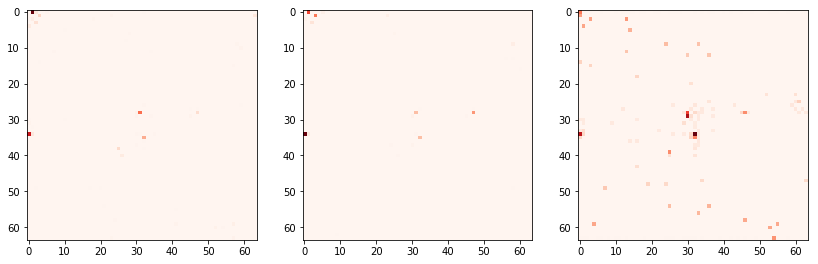

In [19]:
f, ax = plt.subplots(1,3,figsize=(14,6))
for i in range(3):
    ax[i].imshow(X_train[100,i,:,:], cmap="Reds")

### As usual split the train data to train and validation samples.

In [20]:
from sklearn.cross_validation import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.5, random_state=42)

/home/shirobokov/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## The next steps are exactly the same as was on cifar seminar to Tuesday

In [21]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

### This is dummy example of CNN, look what you can change here(HINT: look at cifar seminar cheatsheet)

In [22]:
model = torch.nn.Sequential()
model.add_module("maxpool_1", torch.nn.MaxPool2d(kernel_size=2))
model.add_module('conv_1', nn.Conv2d(3, 32, kernel_size=(5,5), stride=1, padding=0))
model.add_module("maxpool_2", torch.nn.MaxPool2d(kernel_size=2))
model.add_module("relu_1", torch.nn.ReLU())

model.add_module("flat", Flatten())

model.add_module("fc1", torch.nn.Linear(6272, 128))
model.add_module("relu_2", torch.nn.ReLU())
model.add_module("fc2", torch.nn.Linear(128, 1))
model.add_module("sigmoid", torch.nn.Sigmoid())

model.cuda(0)

Sequential(
  (maxpool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_1): Conv2d (3, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (relu_1): ReLU()
  (flat): Flatten(
  )
  (fc1): Linear(in_features=6272, out_features=128)
  (relu_2): ReLU()
  (fc2): Linear(in_features=128, out_features=1)
  (sigmoid): Sigmoid()
)

### Training on minibatches

Just like before, we train our model on small random minibatches of data with adaptive optimization method of your choice.

In [23]:
# An auxilary function that returns mini-batches for neural network training
from tqdm import trange
def iterate_minibatches(X, y, batchsize, shuffle=False):
    indices = np.arange(len(X))
    if shuffle: 
        indices = np.random.permutation(indices)
    for start in trange(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

### Choose you optimiser

In [24]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

## And set up batch_size and number of epochs

In [25]:
import time
from pandas import ewma
from IPython import display

num_epochs = 50 #amount of passes through the data
batch_size = 1024 #number of samples processed at each function call
auc_history = []

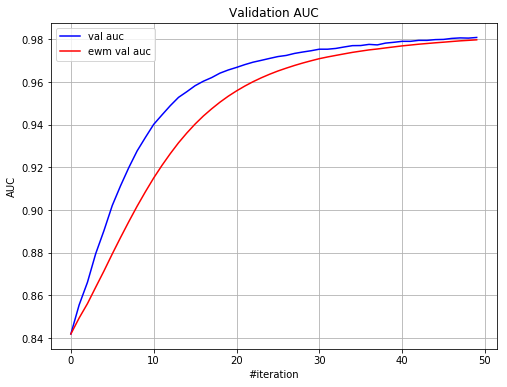

Epoch 50 of 50 took 2.122s
  training loss (in-iteration):		0.145370
  train accuracy:		106.51 %
  validation accuracy:		92.86 %
  validation roc_auc:		98.09 %


In [26]:
for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    
    train_err = train_acc = 0
    start_time = time.time()
    
    # This is you have see already - traning loop
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
        X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
        y_batch = Variable(torch.FloatTensor(y_batch)).cuda(0)
        
        y_predicted = model(X_batch)
        loss = torch.nn.functional.binary_cross_entropy(y_predicted, y_batch).mean()
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_err += loss.data.cpu().numpy()[0]
        train_acc += torch.eq(torch.round(y_predicted), y_batch).data.cpu().numpy().mean()

    # And a full pass over the validation data:
    y_pred = []
    
    model.train(False)
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, shuffle=False):
        X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
        y_pred.extend(model(X_batch).data.cpu().numpy())
        
    y_pred = np.asarray(y_pred)
    # Save the metrics values   
    val_acc = accuracy_score(y_val, y_pred > 0.5)
    val_roc_auc = roc_auc_score(y_val, y_pred)
    auc_history.append(val_roc_auc)

    
    
    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
    plt.title("Validation AUC")
    plt.xlabel("#iteration")
    plt.ylabel("AUC")
    plt.plot(auc_history, 'b',label='val auc')
    plt.plot(ewma(np.array(auc_history), span=10),'r',label='ewm val auc')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    train_batches = np.ceil(len(X_train) // batch_size)
    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(val_acc * 100))
    print("  validation roc_auc:\t\t{:.2f} %".format(val_roc_auc * 100))

# Read test data, feed it to neural network, and save the output in kaggle fromat.

In [29]:
X_test, non_var = read_data(test, is_train=False)
dummy_y = np.array(range(len(X_test)))

In [30]:
model.train(False)
y_pred = []
for X_batch, y_batch in iterate_minibatches(X_test, dummy_y, batch_size, shuffle=False):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda(0)
    y_pred.extend(model(X_batch).data.cpu().numpy())

y_predicted = np.asarray(y_pred)

100%|██████████| 135/135 [00:14<00:00,  9.44it/s]


Saving you results to file.

In [31]:
import pandas as pd
from IPython.display import FileLink

def save_results(filename, y_ans):
    answer_dataframe = pd.DataFrame(columns=["ID", "ans"])
    answer_dataframe['ID'] = range(0,len(y_ans))
    answer_dataframe['ans'] = y_ans
    answer_dataframe.to_csv('{}'.format(filename), index=False)
    return FileLink('{}'.format(filename))

In [32]:
save_results("baseline.csv", y_predicted)

/home/shirobokov/ICL/baseline.csv